# Emotions Detection in Text

In [73]:
# EDA
import pandas as pd
import re

# Load Data Viz Pkgs
import seaborn as sns

# Load Text Cleaning Pkgs
import neattext.functions as nfx

# Text processing libraries
import contractions

# Load ML Pkgs
# Estimators
from sklearn.linear_model import LogisticRegression

# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [74]:
# Load Dataset
df = pd.read_csv('../data/goemotions_full.csv')

In [75]:
df.head(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
# Dropping remaining unnecessary things for training
df.drop('id', inplace=True, axis=1)
df.drop('example_very_unclear', inplace=True, axis=1)
df.drop('author', inplace=True, axis=1)
df.drop('subreddit', inplace=True, axis=1)
df.drop('link_id', inplace=True, axis=1)
df.drop('parent_id', inplace=True, axis=1)
df.drop('created_utc', inplace=True, axis=1)
df.drop('rater_id', inplace=True, axis=1)


In [77]:
df.columns

Index(['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride',
       'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [78]:
df.shape

(211225, 29)

In [79]:
emotions = set(df.columns[1:])
emotions


{'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise'}

In [80]:
positive = {'admiration','amusement','approval','caring','excitement','gratitude','joy','love','optimism','pride','relief'}
negative = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness','remorse','grief','disgust'}
ambiguous = {'realization','surprise','curiosity','confusion','neutral','desire'}

print(f'Fine grained emotions: {len(emotions)}')
print(f'Number of data: {len(df)}')
print(f'Number of positive emotions: {len(positive)}') 
print(f'Number of negative emotions: {len(negative)}')
print(f'Number of ambiguous emotions: {len(ambiguous)}')

Fine grained emotions: 28
Number of data: 211225
Number of positive emotions: 11
Number of negative emotions: 11
Number of ambiguous emotions: 6


In [81]:
df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = ''
df_emotion['group'].loc[df_emotion['emotion'].isin(positive)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(negative)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(ambiguous)] = 'ambiguous'
df_emotion = df_emotion.sort_values(by='group')
df_emotion

,emotion,group
16,curiosity,ambiguous
26,desire,ambiguous
12,surprise,ambiguous
5,neutral,ambiguous
18,confusion,ambiguous
15,realization,ambiguous
14,disapproval,negative
21,disappointment,negative
23,nervousness,negative
13,remorse,negative


In [82]:
# Function for cleaning text
def clean_text(text):
  re_number = re.compile('[0-9]+')
  re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
  re_tag = re.compile('\[[A-Z]+\]')
  re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
  re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
  re_punc = re.compile('[?!,.\'\"]')
  
  text = re.sub(re_char, "", text) # Remove unknown character 
  text = contractions.fix(text) # Expand contraction
  text = re.sub(re_url, ' [url] ', text) # Replace URL with number
  text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
  #text = re.sub(re_punc, "", text) # Remove punctuation.
  text = text.lower() # Lower text
  text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

  return text

In [83]:
data = pd.read_csv('../data/goemotions_full.csv')

In [84]:
data["cleaned_text"] = data["text"].apply(clean_text)

In [85]:
# Preview of data
display(data[['text', 'cleaned_text']].sample(5))

,text,cleaned_text
118563,Oh [NAME] I forgot all about this site for goo...,oh name i forgot all about this site for good ...
31436,We have no other winger bro....,we have no other winger bro....
54746,"> Obs streamlabs Thank you buddy, I will take ...","obs streamlabs thank you buddy, i will take a..."
191604,"I think I translates more into ""Waiting to see...",i think i translates more into waiting to see ...
57865,"Me too, whenever my friends get with people I ...","me too, whenever my friends get with people i ..."


In [86]:
# Dropping remaining unnecessary things for training
data.drop('id', inplace=True, axis=1)
data.drop('example_very_unclear', inplace=True, axis=1)
data.drop('author', inplace=True, axis=1)
data.drop('subreddit', inplace=True, axis=1)
data.drop('link_id', inplace=True, axis=1)
data.drop('parent_id', inplace=True, axis=1)
data.drop('created_utc', inplace=True, axis=1)
data.drop('rater_id', inplace=True, axis=1)


In [87]:
data['emotion'] = (data.iloc[:, 1:] == 1).idxmax(1)
data.head(5)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text,emotion
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,that game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sexuality should not be a grouping category i...,admiration
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"you do right, if you do not care then fuck them!",neutral
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,man i love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"name was nowhere near them, he was by the falc...",neutral


In [88]:
# Reorganizing DataFrame (for sanity)
temp_data = pd.merge(data, df_emotion, on='emotion', how='left')
temp_data = temp_data[['cleaned_text', 'emotion', 'group']]

In [89]:
temp_data

,cleaned_text,emotion,group
0,that game hurt.,sadness,negative
1,sexuality should not be a grouping category i...,admiration,positive
2,"you do right, if you do not care then fuck them!",neutral,ambiguous
3,man i love reddit.,love,positive
4,"name was nowhere near them, he was by the falc...",neutral,ambiguous
...,...,...,...
211220,everyone likes name.,love,positive
211221,well when you have imported about a gazillion ...,caring,positive
211222,that looks amazing,admiration,positive
211223,the fda has plenty to criticize. but like here...,anger,negative


In [90]:
data = temp_data[['cleaned_text', 'group']]
data = data.rename(columns={'group': 'emotion'})
data = data[data['cleaned_text'] != '']

# Preview of data   
display(data.head(5))

,cleaned_text,emotion
0,that game hurt.,negative
1,sexuality should not be a grouping category i...,positive
2,"you do right, if you do not care then fuck them!",ambiguous
3,man i love reddit.,positive
4,"name was nowhere near them, he was by the falc...",ambiguous


<Axes: xlabel='emotion', ylabel='count'>

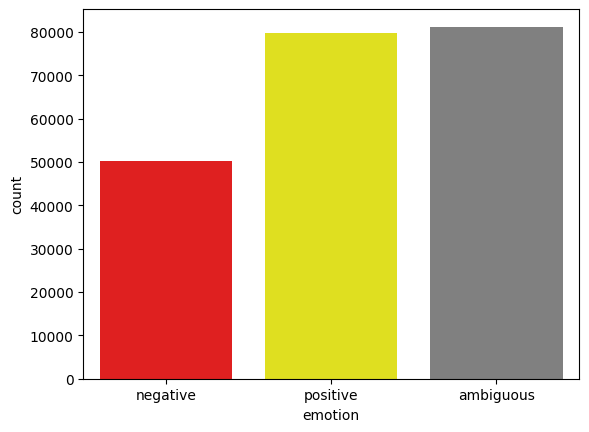

In [91]:
# Plot
sns.countplot(x = 'emotion', data = data, hue = data['emotion'], palette=["red", "yellow", "grey"])

In [92]:
# Features & Labels
Xfeatures = data['cleaned_text']
ylabels = data['emotion']

It is advisable to split before applying pipelines because it prevents data leakage.

In [93]:
#  Split Data
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

In [94]:
# Build Pipeline
from sklearn.pipeline import Pipeline

In [95]:
# LogisticRegression Pipeline
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(max_iter=1000))])

In [96]:
# Train and Fit Data
pipe_lr.fit(x_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [97]:
Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [98]:
# Check Accuracy
pipe_lr.score(x_test,y_test)

0.6268543652547187

In [99]:
# Make A Prediction
ex1 = "The weather today is neither too hot nor too cold. It's a typical day with no particular events. I finished my work and am heading home. The routine continues, and everything seems calm and ordinary. There are no strong emotions, just a sense of normalcy in the air."
pipe_lr.predict([ex1])

array(['ambiguous'], dtype=object)

In [100]:
# Prediction Prob
pipe_lr.predict_proba([ex1])

array([[0.67546942, 0.07209897, 0.25243161]])

In [101]:
# To Know the classes
pipe_lr.classes_

array(['ambiguous', 'negative', 'positive'], dtype=object)

In [102]:
# Save Model & Pipeline
import joblib
pipeline_file = open("../models/emotion_classifier_pipe_lr.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()